In [578]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV

In [579]:
df_train_titanic = pd.read_csv('train_titanic.csv')
df_test_titanic = pd.read_csv('test_titanic.csv')
df_gender_submission = pd.read_csv('gender_submission.csv')

In [580]:
df_test_titanic = df_test_titanic.merge(df_gender_submission, on='PassengerId')

In [581]:
df_test_titanic.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'],
      dtype='object')

In [582]:
df_test_titanic = df_test_titanic[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked']]

PassengerId - Уникальный номер пассажира  
Pclass - класс билета  
Name - Имя  
Sex - Пол  
Age - Возраст  
SibSp - кол-во братьев, сестер, супругов на борту  
Parch - кол-во родителей, детей на борту  
Ticket - номер билета  
Fare - тариф  
Cabin - номер кабины  
Embarked - Пункт посадки пассажиров
Survived - статус пассажира: выжил - 1; погиб - 0

In [583]:
df_test_titanic.info()
df_train_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 42.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived

In [584]:
df = pd.concat([df_train_titanic, df_test_titanic], ignore_index=True, axis=0)

In [585]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [586]:
df.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

Столбцы Survived, Pclass, Sex, Embarked - явно являются номинативными данными, так как служат для разделения пассажиров на классы/группы.
Столбцы SibSp, Parch - являются дискретными значениями, так как отображают кол-во родственников у каждого пассажира.
Теперь можно наглядно оценить влияние принадлежности пассажиров к той или иной группе/категории на интересующий нас результат (выжил/не выжил)

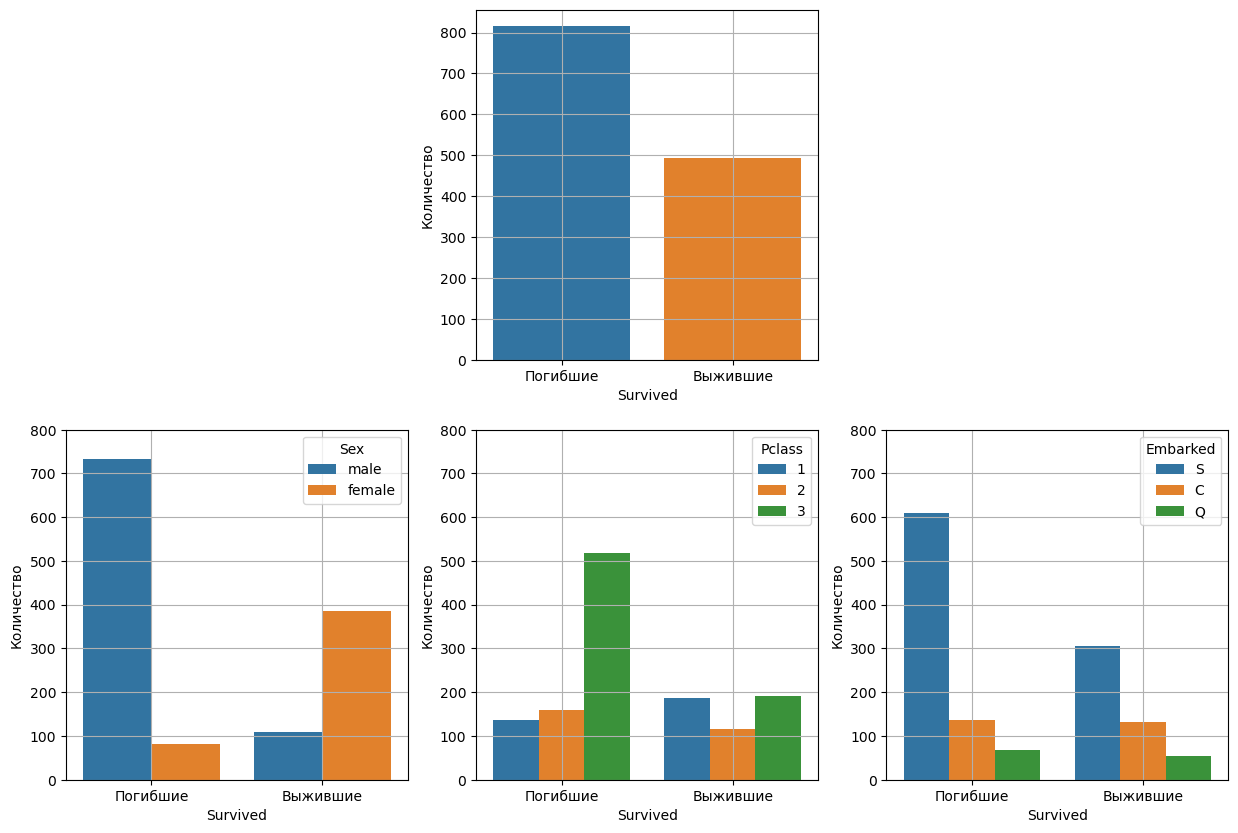

In [587]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 2)
sns.countplot(data=df, x='Survived')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Погибшие', 'Выжившие'])
plt.grid(True)

plt.subplot(2, 3, 4)
sns.countplot(data=df, x='Survived', hue='Sex')
plt.ylabel('Количество')
plt.yticks(ticks=range(0, 850, 100))
plt.xticks([0, 1], ['Погибшие', 'Выжившие'])
plt.grid(True)

plt.subplot(2, 3, 5)
sns.countplot(data=df, x='Survived', hue='Pclass')
plt.ylabel('Количество')
plt.yticks(ticks=range(0, 850, 100))
plt.xticks([0, 1], ['Погибшие', 'Выжившие'])
plt.grid(True)

plt.subplot(2, 3, 6)
sns.countplot(data=df, x='Survived', hue='Embarked')
plt.ylabel('Количество')
plt.yticks(ticks=range(0, 850, 100))
plt.xticks([0, 1], ['Погибшие', 'Выжившие'])
plt.grid(True)

plt.show()

In [588]:
round(df.Survived.value_counts(normalize=True) * 100, 2)

0    62.26
1    37.74
Name: Survived, dtype: float64

In [589]:
round(df.Sex.value_counts(normalize=True) * 100, 2)

male      64.4
female    35.6
Name: Sex, dtype: float64

Глядя на графики можно сделать сл. выводы: 
- Прямое сравнение групп (Выжившие, погибшие) показало что погибших значительно больше выживших, а именно соотношение 62,3% к 37,7%;
- Разделение пассажиров по половому признаку показало, что абсолютное количество выживших пассажиров женского пола кратно больше, чем мужчин, даже с учетом того, что доля мужчин среди всех пассажиров равняется 64,4%;
- Круиз на Титанике третьим классом значительно уменьшает шансы на выживание. Количество погибших пассажиров 1 и 2 классов не значительно отличается от количества выживших пассажиров тех же классов. Тогда как погибших пассажиров 3 класса значительно больше выживших.
Расчитаем относительные показатели доли выживших и погибших для каждого из признаков.

In [590]:
Sex_df = pd.DataFrame({'survivors':{'male':round(len(df[(df.Sex == 'male') & (df.Survived == 1)]) / len(df[df.Sex == 'male']), 2) * 100,\
                                    'female':round(len(df[(df.Sex == 'female') & (df.Survived == 1)]) / len(df[df.Sex == 'female']), 2) * 100},\
                       'dead':{'male':round(len(df[(df.Sex == 'male') & (df.Survived == 0)]) / len(df[df.Sex == 'male']), 2) * 100,\
                               'female':round(len(df[(df.Sex == 'female') & (df.Survived == 0)]) / len(df[df.Sex == 'female']), 2) * 100}})
Class_df = pd.DataFrame({'survivors':{'Class_1':round(len(df[(df.Pclass == 1) & (df.Survived == 1)]) / len(df[df.Pclass == 1]), 2) * 100,\
                                      'Class_2':round(len(df[(df.Pclass == 2) & (df.Survived == 1)]) / len(df[df.Pclass == 2]), 2) * 100,\
                                      'Class_3':round(len(df[(df.Pclass == 3) & (df.Survived == 1)]) / len(df[df.Pclass == 3]), 2) * 100},\
                         'dead':{'Class_1':round(len(df[(df.Pclass == 1) & (df.Survived == 0)]) / len(df[df.Pclass == 1]), 2) * 100,\
                                 'Class_2':round(len(df[(df.Pclass == 2) & (df.Survived == 0)]) / len(df[df.Pclass == 2]), 2) * 100,\
                                 'Class_3':round(len(df[(df.Pclass == 3) & (df.Survived == 0)]) / len(df[df.Pclass == 3]), 2) * 100}})
Embarced_df = pd.DataFrame({'survivors':{'S':round(len(df[(df.Embarked == 'S') & (df.Survived == 1)]) / len(df[df.Embarked == 'S']), 2) * 100,\
                                         'C':round(len(df[(df.Embarked == 'C') & (df.Survived == 1)]) / len(df[df.Embarked == 'C']), 2) * 100,\
                                         'Q':round(len(df[(df.Embarked == 'Q') & (df.Survived == 1)]) / len(df[df.Embarked == 'Q']), 2) * 100},\
                            'dead':{'S':round(len(df[(df.Embarked == 'S') & (df.Survived == 0)]) / len(df[df.Embarked == 'S']), 2) * 100,\
                                    'C':round(len(df[(df.Embarked == 'C') & (df.Survived == 0)]) / len(df[df.Embarked == 'C']), 2) * 100,\
                                    'Q':round(len(df[(df.Embarked == 'Q') & (df.Survived == 0)]) / len(df[df.Embarked == 'Q']), 2) * 100}})
Sex_df['Sum'] = Sex_df.sum(axis=1)
Class_df['Sum'] = Class_df.sum(axis=1)
Embarced_df['Sum'] = Embarced_df.sum(axis=1)

In [591]:
Sex_df

,survivors,dead,Sum
male,13.0,87.0,100.0
female,83.0,17.0,100.0


In [592]:
Class_df

,survivors,dead,Sum
Class_1,58.0,42.0,100.0
Class_2,42.0,58.0,100.0
Class_3,27.0,73.0,100.0


In [593]:
Embarced_df

,survivors,dead,Sum
S,33.0,67.0,100.0
C,49.0,51.0,100.0
Q,44.0,56.0,100.0


- Доля выживших мужчин составляет всего 13,0% от всех мужчин, тогда как доля выживших женщин равна 83,0%;
- Среди всех пассажиров 1 класса 58,0% оказались спасены, пассажиров 2 класса спаслось всего 42,0%, что уже меньше половины пассажиров этого класса. А доля спасшихся/выживших пассажиров 3 класса составила всего 27,0% от пассажиров этого класса;
- Доли выживших и погибших между пассажирами, попавшими на борт судна в портах "C" и "Q" распределены более равномерно, чем у пассажиров из порта "S".
Однозначно можно сказать, что на шанс пассажира оказаться выжившим значительно влияют пол пассажира и класс, которым он путешествует.

Чтобы убедиться, что каждый из признаков оказывает влияние на распределение пассажиров между погибшими и выжившими можно расчитать хи квадрат Пирсона для каждого признака.

1. Пол пассажира.
H0: между наблюдаемым распределение и ожидаемым распределением нет различий;
Н1: между наблюдаемым распределение и ожидаемым распределением различия существенны.
уровень значимости - 0,05.

In [594]:
x = [[len(df[(df.Sex == 'male') & (df.Survived == 1)]),\
      len(df[(df.Sex == 'male') & (df.Survived == 0)])],\
     [len(df[(df.Sex == 'female') & (df.Survived == 1)]),\
      len(df[(df.Sex == 'female') & (df.Survived == 0)])]]
chi2, prob, deg_fr, expected = chi2_contingency(x)
print(f'Statistics - {round(chi2, 2)}; p-value - {prob}; degrees of freedom - {deg_fr}')

Statistics - 617.31; p-value - 2.871410444001617e-136; degrees of freedom - 1


2. Класс пассажира.
H0: между наблюдаемым распределение и ожидаемым распределением нет различий;
Н1: между наблюдаемым распределение и ожидаемым распределением различия существенны.
уровень значимости - 0,05.

In [595]:
x = [[len(df[(df.Pclass == 1) & (df.Survived == 1)]),\
      len(df[(df.Pclass == 1) & (df.Survived == 0)])],\
     [len(df[(df.Pclass == 2) & (df.Survived == 1)]),\
      len(df[(df.Pclass == 2) & (df.Survived == 0)])],\
     [len(df[(df.Pclass == 3) & (df.Survived == 1)]),\
      len(df[(df.Pclass == 3) & (df.Survived == 0)])]]
chi2, prob, deg_fr, expected = chi2_contingency(x)
print(f'Statistics - {round(chi2, 2)}; p-value - {(prob)}; degrees of freedom - {deg_fr}')

Statistics - 91.72; p-value - 1.2090852275863937e-20; degrees of freedom - 2


3. Порт посадки.
H0: между наблюдаемым распределение и ожидаемым распределением нет различий;
Н1: между наблюдаемым распределение и ожидаемым распределением различия существенны.
уровень значимости - 0,05.

In [596]:
x = [[len(df[(df.Embarked == 'S') & (df.Survived == 1)]),\
      len(df[(df.Embarked == 'S') & (df.Survived == 0)])],\
     [len(df[(df.Embarked == 'C') & (df.Survived == 1)]),\
      len(df[(df.Embarked == 'C') & (df.Survived == 0)])],\
     [len(df[(df.Embarked == 'Q') & (df.Survived == 1)]),\
      len(df[(df.Embarked == 'Q') & (df.Survived == 0)])]]
chi2, prob, deg_fr, expected = chi2_contingency(x)
print(f'Statistics - {round(chi2, 2)}; p-value - {(prob)}; degrees of freedom - {deg_fr}')

Statistics - 24.68; p-value - 4.363583182075015e-06; degrees of freedom - 2


Во всех трех случаях, можно сказать что распределения выживших и погибших пассажиров не равномерные и значительно различаются в зависимости от пола, класса и порта посадки.  
Посмотрим как на показатель влияют возраст пассажира. Однако в столбце Age много пропущенных значений, можно попытаться взять какие-то усредненные значения возраста по группам к которым принадлежат пассажиры без данных по возрасту. Для того чтобы более корректно заполнить пробелы в возрасте пассажиров, разделим для каждого пассажира колонку Name и возмем оттуда обращение (Mrs, Miss и т.д.). Сгруппируем пассажиров по этому признаку и возьмем среднее значение возраста для каждой группы, после чего подставим средний возраст соответствующей группы в недостающие данные по каждому пассажиру согласно обращения к нему.

In [597]:
df['appeal'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [598]:
df.groupby(by='appeal').agg({'Age':['mean', 'median']})

Age       
                   mean median
appeal                        
Capt          70.000000   70.0
Col           54.000000   54.5
Don           40.000000   40.0
Dona          39.000000   39.0
Dr            43.571429   49.0
Jonkheer      38.000000   38.0
Lady          48.000000   48.0
Major         48.500000   48.5
Master         5.482642    4.0
Miss          21.774238   22.0
Mlle          24.000000   24.0
Mme           24.000000   24.0
Mr            32.252151   29.0
Mrs           36.994118   35.5
Ms            28.000000   28.0
Rev           41.250000   41.5
Sir           49.000000   49.0
the Countess  33.000000   33.0

In [599]:
df.appeal[df.Age.isnull()].value_counts()

Mr        176
Miss       50
Mrs        27
Master      8
Dr          1
Ms          1
Name: appeal, dtype: int64

Различия в возрасте между классами обращения к человеку достаточно значимые. Возьмем медианное значение для заполнения пропусков.

In [600]:
def get_age(appeal):
    for k, v in df.groupby(by='appeal').median()[['Age']].to_dict(orient='dict')['Age'].items():
        if appeal == k:
            return v

In [601]:
df['age2'] = df.appeal.apply(lambda x: get_age(x))
df.Age.fillna(round(df.age2, 2), inplace=True)
df.drop(columns='age2', inplace=True)

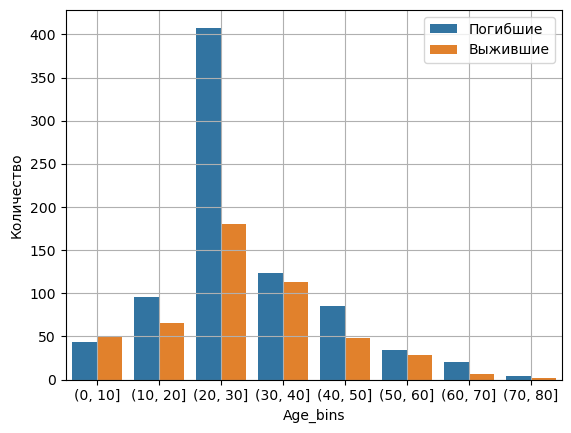

In [602]:
df['Age_bins'] = pd.cut(df.Age, range(int(df.Age.min()), int(df.Age.max() + 1), 10))
sns.countplot(x=df.Age_bins, hue=df.Survived)
plt.legend(labels=(['Погибшие', 'Выжившие']))
plt.ylabel('Количество')
plt.grid(True)
plt.show()

In [603]:
df.Age.describe()

count    1309.000000
mean       29.432521
std        13.163767
min         0.170000
25%        22.000000
50%        29.000000
75%        35.500000
max        80.000000
Name: Age, dtype: float64

Из описательной статистики видно, что средний возраст пассажиров составляет почти 30 лет, 50% всех пассажиров находятся в возрасте от 22 до 36 лет. На графике видно, что в группе пассажиров от 0 до 10 лет, количество виживших превышает количество погибших, однако в остальных группах данная тенденция обратная.
Используя t-тест Стьюдента, можем узнать имеет ли статистическую значимость средний возраст пассажиров для разделения на выживших и погибших. Для этого разобьем данные на две выборки и посмотрим плотность распределения в них.

In [604]:
df.Age[df.Survived == 1].describe()

count    494.000000
mean      28.644251
std       14.162971
min        0.170000
25%       21.250000
50%       28.000000
75%       35.875000
max       80.000000
Name: Age, dtype: float64

In [605]:
df.Age[df.Survived == 0].describe()

count    815.000000
mean      29.910319
std       12.504186
min        0.330000
25%       22.000000
50%       29.000000
75%       35.000000
max       74.000000
Name: Age, dtype: float64

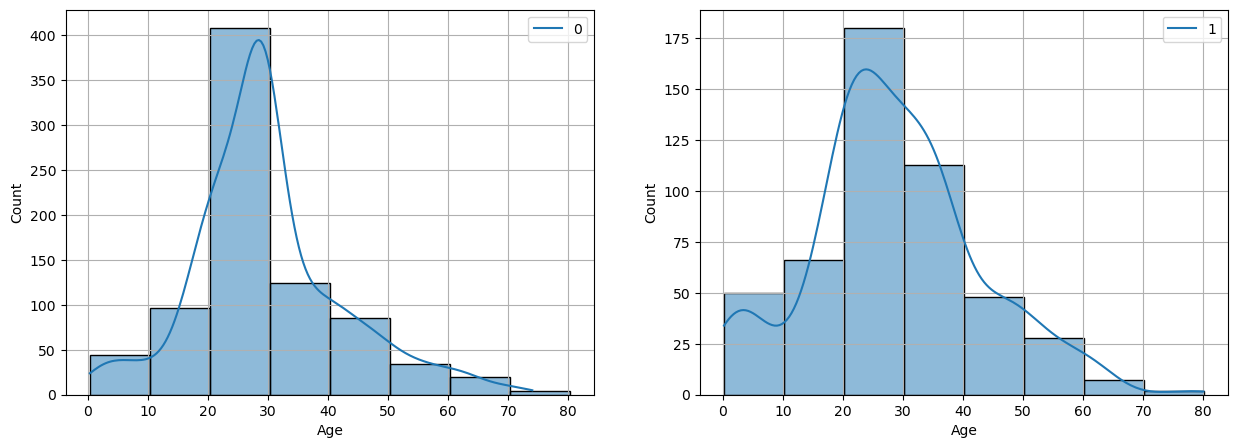

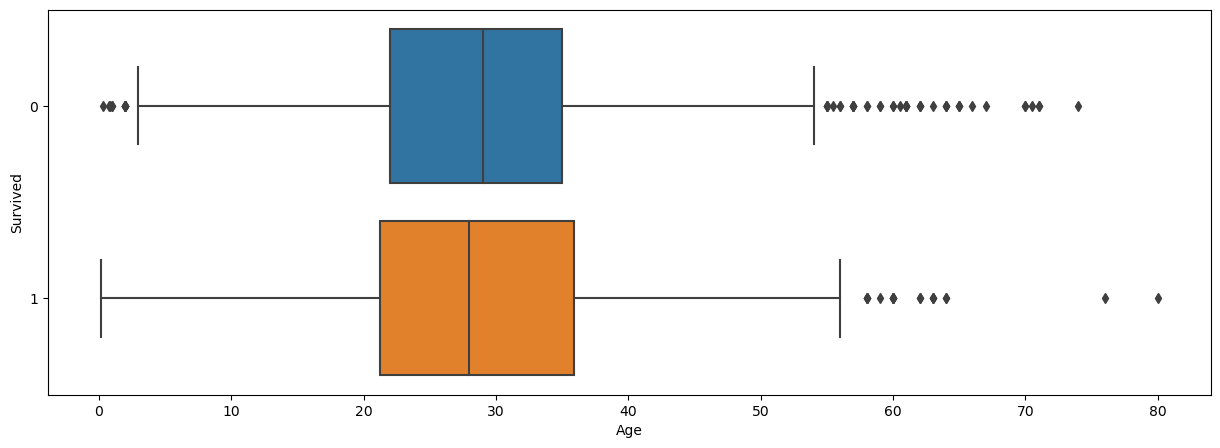

In [606]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=df.Age[df.Survived == 0], binwidth=10, kde=True)
plt.legend('0')
plt.grid(True)
plt.subplot(1, 2, 2)
sns.histplot(x=df.Age[df.Survived == 1], binwidth=10, kde=True)
plt.legend('1')
plt.grid(True)

plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x=df.Age, y=df.Survived, orient='h')
plt.show()

Для проверки стат. значимости возраста для определения выжил пассажир или нет, сформируем нулевую гипотезу: средний возраст пассажиров выживших равен среднему возрасту погибших пассажиров. Уровень значимости 5%.

In [607]:
statistic, pvalue = stats.ttest_ind(df.Age[df.Survived == 0], df.Age[df.Survived == 1])
print(f't-statistic={round(statistic, 2)}, p-value={round(pvalue, 4)}')

t-statistic=1.69, p-value=0.0917


C:\Users\EVOspeed\AppData\Local\Temp\ipykernel_8180\3921302867.py:1: DeprecationWarning: Please use `ttest_ind` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  statistic, pvalue = stats.ttest_ind(df.Age[df.Survived == 0], df.Age[df.Survived == 1])


Так как p-value больше установленного уровеня значимости 0,05, у нас не достаточно основания для отклонения Н0, соответственно можно сделать вывод, что средный возраст погибших и выживших не имеет статистически значимой разницы.

Посмотрим как тарифы (Fare) отличаются у выживших и погибших. Но для начало восполним пробел

In [608]:
df[df.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,appeal,Age_bins
1043,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,"(60, 70]"


Пропущенно всего одна значение у пассажира мужчины в третьем классе, для заполнения возмем средний тариф у мужчин путешествующих третьим классом.

In [609]:
df.Fare.fillna(df.Fare[(df.Pclass == 3) & (df.Sex == 'male')].mean(), inplace=True)

In [610]:
df.Fare[df.Survived == 0].describe()

count    815.000000
mean      23.865059
std       34.887809
min        0.000000
25%        7.854200
50%       10.500000
75%       26.000000
max      263.000000
Name: Fare, dtype: float64

In [611]:
df.Fare[df.Survived == 1].describe()

count    494.000000
mean      48.811497
std       68.594401
min        0.000000
25%       11.431275
50%       26.000000
75%       56.982300
max      512.329200
Name: Fare, dtype: float64

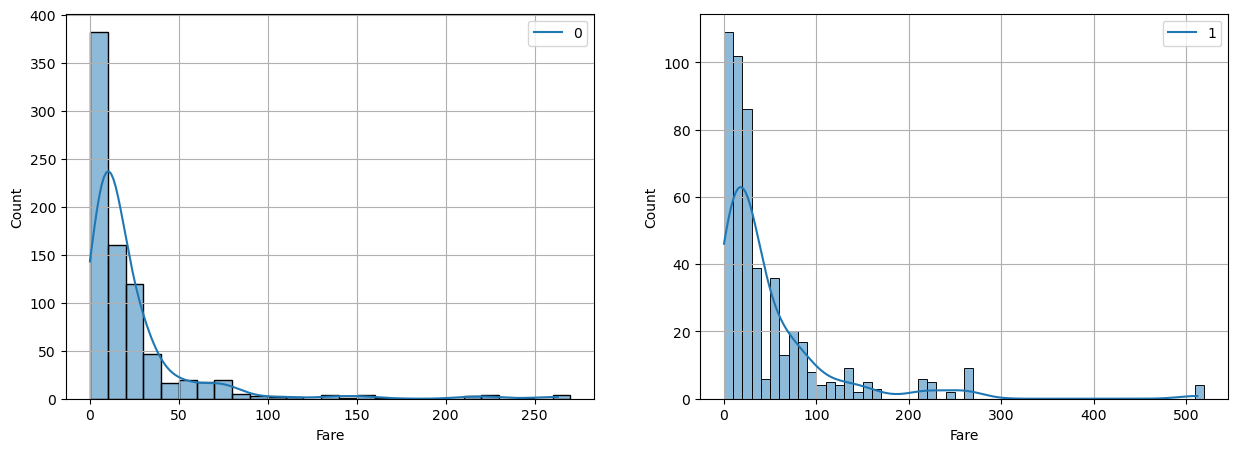

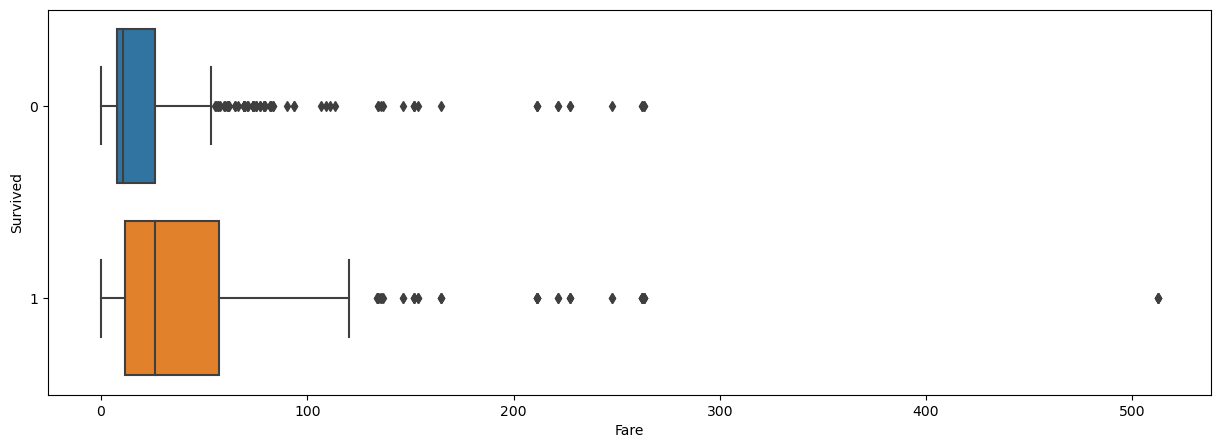

In [612]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(x=df.Fare[df.Survived == 0], binwidth=10, kde=True)
plt.legend('0')
plt.grid(True)
plt.subplot(1, 2, 2)
sns.histplot(x=df.Fare[df.Survived == 1], binwidth=10, kde=True)
plt.legend('1')
plt.grid(True)

plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x=df.Fare, y=df.Survived, orient='h')
plt.show()

Распределение тарифов имеет ярко выраженную правостороннюю ассиметрию, что видно на графиках и из показателей описательной статистики, при этом у данных большое количество выбросов. Также можно заметить, что у выживших пассажиров в среднем тариф выше, возможно данный показатель коррелирует с классом пассажира.   
Так как параметрические критерии чувствительны к выбрасам, для сравнения выборок будем использовать непараметрический тест.

In [613]:
statistic, pvalue = mannwhitneyu(x=df.Fare[df.Survived == 1], y=df.Fare[df.Survived == 0],\
                                 alternative='two-sided')
print(f't-statistic={round(statistic, 2)}, p-value={round(pvalue, 4)}')

t-statistic=269668.0, p-value=0.0


Значение p-value значительно ниже 0,05, что дает нам основание полагать,, что тириф значимо отличается у выживших и погибших пассажиров.

Для визуализации распределения пассажиров между погибшими и выжившимы с учетом количества родственников, находящихся на корабле. Можно объеденить столбцы SibSp, Parch, где сумма столбцов равная 0 будет означать что пассажир находился на корабле без родственников, а сумма отличная от 0 будет показывать количество всех родственников данного пасажира, находящихся на корабле.

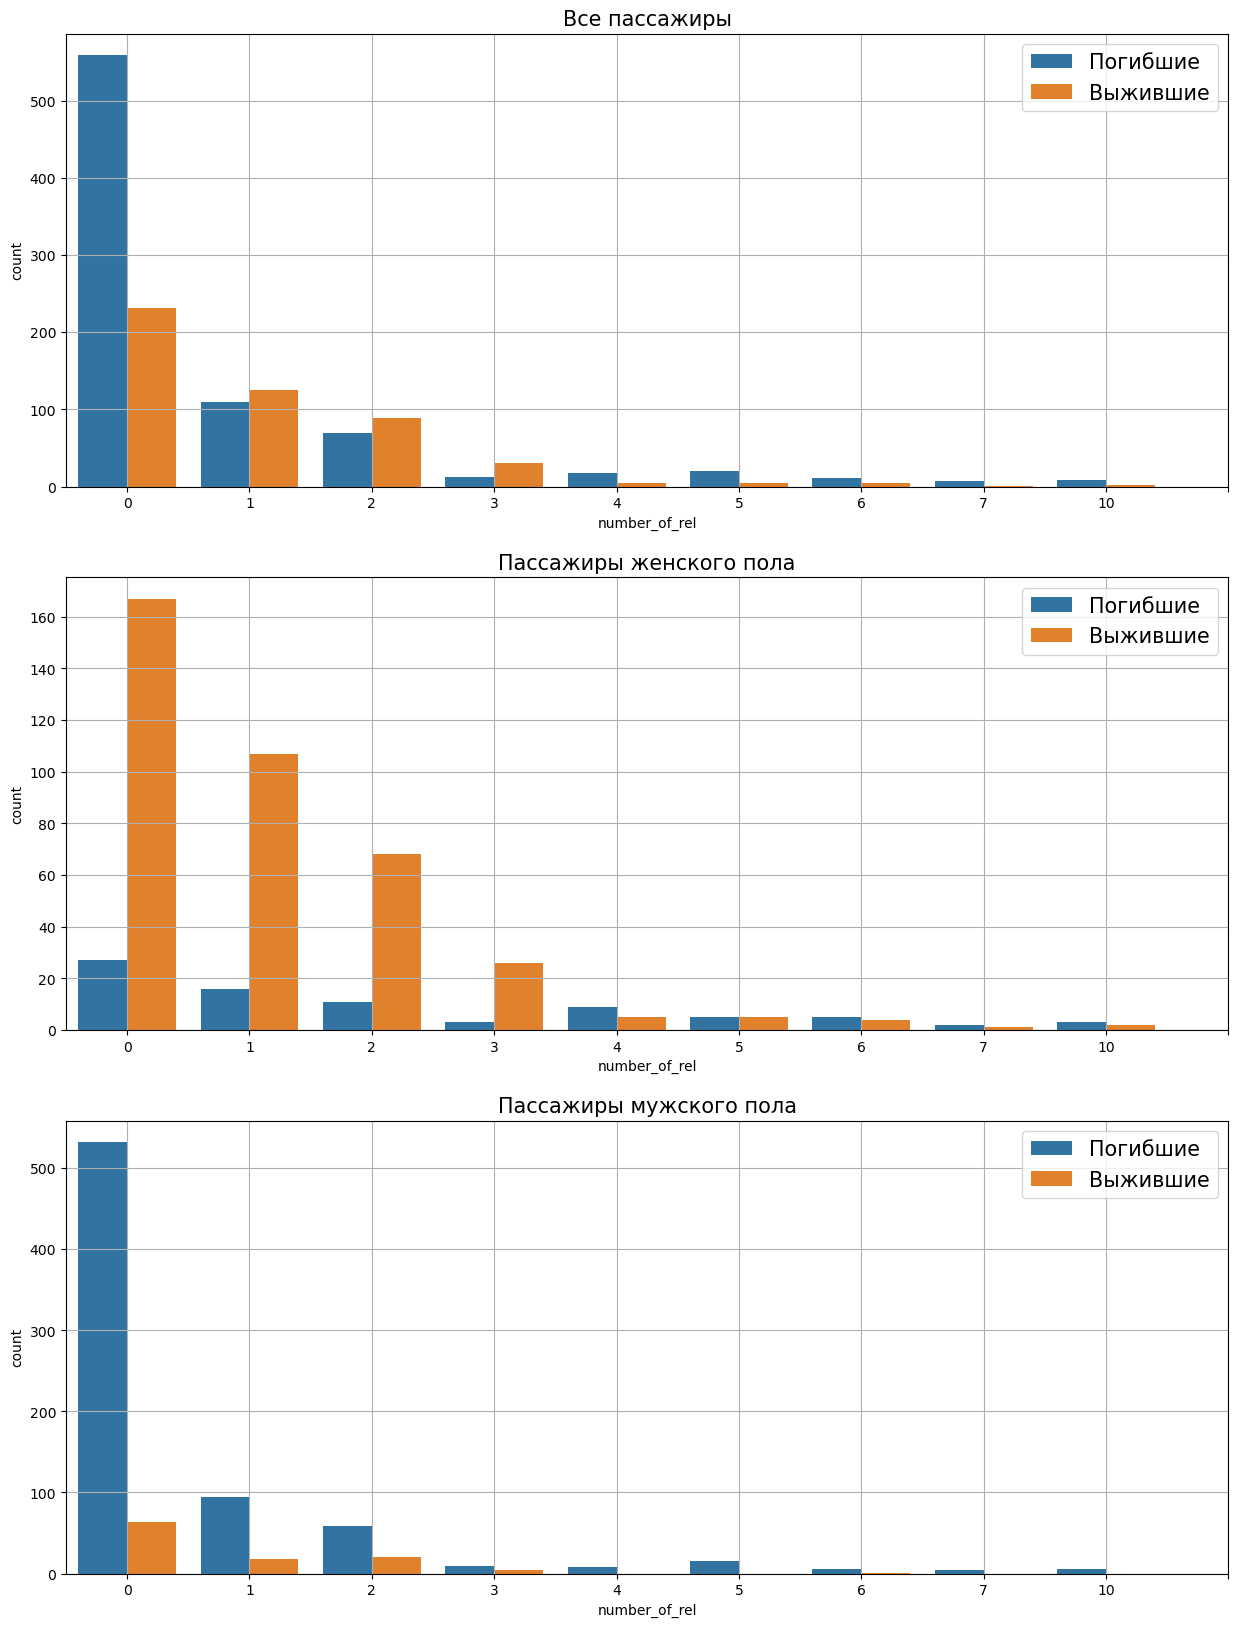

In [614]:
df['number_of_rel'] = df.SibSp + df.Parch

plt.figure(figsize=(15, 20))

plt.subplot(3, 1, 1)
sns.countplot(x=df.number_of_rel, hue=df.Survived)
plt.legend(labels=(['Погибшие', 'Выжившие']), fontsize=15)
plt.xticks(ticks=range(0, 10, 1))
plt.title('Все пассажиры', fontdict={'fontsize':15})
plt.grid(True)

plt.subplot(3, 1, 2)
sns.countplot(x=df.number_of_rel[df.Sex == 'female'], hue=df.Survived)
plt.legend(labels=(['Погибшие', 'Выжившие']), fontsize=15)
plt.xticks(ticks=range(0, 10, 1))
plt.title('Пассажиры женского пола', fontdict={'fontsize':15})
plt.grid(True)

plt.subplot(3, 1, 3)
sns.countplot(x=df.number_of_rel[df.Sex == 'male'], hue=df.Survived)
plt.legend(labels=(['Погибшие', 'Выжившие']), fontsize=15, loc='upper right')
plt.xticks(ticks=range(0, 10, 1))
plt.title('Пассажиры мужского пола', fontdict={'fontsize':15})
plt.grid(True)

plt.show()

Изходя из графика, видно что большинство людей находились на корабле без родственников. Можно выделить интересную взаимосвязь, что доля выживших пассажиров у которых на корабле было от 1 до 3 родственников включительно превышает долю погибших в этих группах. Но при разделении пассажиров по половому признаку видно, что данная тенденция сохраняется, только у пассажиров женского пола, тогда как у мужского контенгента нет шансов)

Восполним оставшиеся пустые значения в данных. Для порта отправки возьмем модальное значение. Столбец Cabin почти пустой, лучше всего его удалить.

In [615]:
df.Embarked.fillna('S', inplace=True)
df.drop(columns='Cabin', inplace=True)

В слосбцах Sex и Embarked заменим текстовые значения числами.

In [616]:
sex = {'male':0, 'female':1}

def substitute(i):
    for k, v in sex.items():
        if i == k:
            return v

In [617]:
df.Sex = df.Sex.map(substitute)

In [618]:
embarked = {}
cnt = 0
for i in df.Embarked.values:
        if i not in embarked.keys():
            embarked.setdefault(i, cnt)
            cnt += 1
            
def emb_n(emb):
    for k, v in embarked.items():
        if emb == k:
            return v

In [619]:
df['emb_n'] = df.Embarked.map(emb_n)

Удалим лишние столбцы. В том числе и Age так как не обнаружили особой разницы в среднем возрасте между выборками и признак довольно сильно коррелирует с другими независимымы признаками (Pclass, number_of_rel).

In [620]:
df.drop(columns=['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked', 'appeal', 'Age_bins', 'Age', 'number_of_rel'], inplace=True)

<AxesSubplot:>

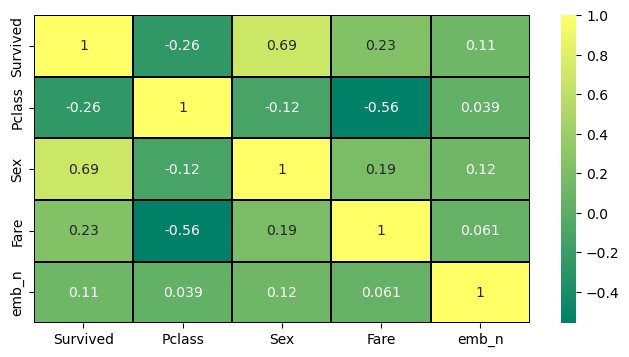

In [621]:
plt.figure(figsize=(8, 4))
sns.heatmap(df.corr(), linecolor='black', linewidths=0.2, cmap='summer', annot=True)

Разделим данные на учебные и тренировочные (70/30) и попробуем предсказать погиб или выжил пассажир в учебных данных, основываясь на тренировочных.  
Также закодируем категориальные данные, столбцы Sex, Emb_n, Pclass.  
Нормализуем данные в столбцах Fare.

In [622]:
df.iloc[::, 3:4] = MinMaxScaler(feature_range=(0, 1)).fit_transform(df[['Fare']])

In [623]:
df = pd.concat([df, pd.get_dummies(df.Pclass, prefix='class'),\
                    pd.get_dummies(df.emb_n, prefix='embarked'),\
                    pd.get_dummies(df.Sex, prefix='sex')], axis=1)
df.drop(columns=['Pclass', 'emb_n', 'Sex'], inplace=True)

In [624]:
df_train, df_test = train_test_split(df, test_size=0.3)

In [625]:
len(df_train[df_train.Survived == 1]) / len(df_train)

0.3864628820960699

In [626]:
len(df_test[df_test.Survived == 1]) / len(df_test)

0.356234096692112

In [627]:
x = df_train.drop(columns='Survived')
y = df_train.Survived

In [628]:
model = LogisticRegression(solver='liblinear').fit(x, y)

In [629]:
print(f'Коэффициент детерминации нашей модели составил - {round(model.score(x, y), 2)}\n\
B0 - {model.intercept_,}\n\
Коэффициенты признаков - {model.coef_}')

Коэффициент детерминации нашей модели составил - 0.85
B0 - (array([0.03870346]),)
Коэффициенты признаков - [[ 0.04041072  0.76677776  0.01324877 -0.74132308 -0.08209488  0.14172959
  -0.02093125 -1.70919727  1.74790072]]


In [630]:
df_test['survived_LR_predict'] = model.predict(df_test.drop(columns='Survived'))

In [631]:
df_test.Survived.value_counts()

0    253
1    140
Name: Survived, dtype: int64

In [632]:
df_test.survived_LR_predict.value_counts()

0    260
1    133
Name: survived_LR_predict, dtype: int64

In [633]:
print(classification_report(df_test.Survived, df_test.survived_LR_predict))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       253
           1       0.83      0.79      0.81       140

    accuracy                           0.87       393
   macro avg       0.86      0.85      0.85       393
weighted avg       0.86      0.87      0.86       393



С помощью логистической регрессионной модели основываясь на тестовых данных предсказали статус пассажира (выжил, погиб). Согласно отчета 83% из 133 предсказанных нами выживщих пассажиров оказались действительно выжившими, что в свою очередь составило 79% от всех выживщих в тестовых данных. С погибшими показатели следующие 88% из 260, что составило 91% от всех погибших. Общая точность модели составила 87%.

Попробуем предсказать с помощью алгоритма - RandomForest. И сравним результаты.

Для подбора параметров модели используем RandomizedSearchCV

In [634]:
model_RF = RandomForestClassifier().fit(x, y)

In [642]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
param_distribution = {'n_estimators': n_estimators,
                      'max_features': max_features,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf': min_samples_leaf,}

RS = RandomizedSearchCV(model_RF, param_distributions=param_distribution, 
                        n_iter = 100, cv = 5, verbose = 1, n_jobs=-1, 
                        random_state=0)
RS.fit(x, y)
RS.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 700,
 'min_samples_split': 44,
 'min_samples_leaf': 7,
 'max_features': 'sqrt',
 'max_depth': 8}

In [643]:
model_RF = RandomForestClassifier(n_estimators=700, min_samples_split=44, min_samples_leaf=7, max_features='sqrt', max_depth=8).fit(x, y)

In [644]:
print(f'Коэффициент детерминации нашей модели составил - {round(model_RF.score(x, y), 2)}')

Коэффициент детерминации нашей модели составил - 0.86


In [647]:
df_test['survived_RF_predict'] = model_RF.predict(df_test.drop(columns=['Survived', 'survived_LR_predict']))

In [648]:
print(classification_report(df_test.Survived, df_test.survived_RF_predict))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       253
           1       0.86      0.77      0.82       140

    accuracy                           0.88       393
   macro avg       0.87      0.85      0.86       393
weighted avg       0.87      0.88      0.87       393



In [649]:
df_test.survived_RF_predict.value_counts()

0    268
1    125
Name: survived_RF_predict, dtype: int64

С помощью второй модели основываясь на тестовых данных предсказали статус пассажира (выжил, погиб). Согласно отчета 86% из 125 предсказанных нами выживщих пассажиров оказались действительно выжившими, что в свою очередь составило 77% от всех выживщих в тестовых данных. С погибшими показатели следующие 88% из 268, что составило 93% от всех погибших. Общая точность модели составила тоже 88%.  
В целом модель логистической регрессии показала похожие результаты.